# 贝叶斯向量自回归

**发布日期**: 2019年10月15日

**文章作者**: Xinyu Chen (陈新宇) [[GitHub主页](https://github.com/xinychen)]

**下载**: 本Jupyter Notebook可在GitHub仓库[GraphicalML](https://github.com/mobility-computing/GrapicalML/blob/master/content/bvar.ipynb)中下载和使用。


## 0 关于本文

- 讨论贝叶斯向量自回归模型的形式
- 介绍如何实现贝叶斯向量自回归
- 分析贝叶斯向量自回归的应用

## 1 向量自回归模型

向量自回归模型的英文名称为Vector Autoregressive model，常被简写成VAR。向量自回归的出现由来已久，可以追溯到上个世纪80年代，人们构建向量自回归模型主要出于以下考虑：

- 时间序列分析从单一时间序列 (time series data) 拓展到了多元时间序列 (multivariate time series)，在任意第$t$个时间间隔 (time interval)，观测样本从1变成了$N$，其中，$N$表示多元时间序列中时间序列的数量。
- 标准的自回归模型 (Autoregressive model, 简称AR) 其表达式过于简单，无法很好地在多元时间序列分析中发挥作用。


### 1.1 标准的自回归模型

在统计学、经济学乃至信号处理等领域，自回归模型被广泛应用于描述随时间变化的过程 (简称时变过程)，其中，最为经典的应用当属时间序列分析，在这里，自回归模型假设变量之间存在一个线性的依赖关系，即输出变量 (output variables) 如$y_t$与输入的历史变量 (previous variables) 如$y_{t-1},y_{t-2},...$存在一个线性表达式。

不妨先看一下标准的自回归模型：给定单一时间序列$\boldsymbol{y}\in\mathbb{R}^{T}$，其时间间隔的数量为$T$，则对于任意第$t$个时间间隔，存在如下的线性表达式：
\begin{equation}
y_{t}=\sum_{k=1}^{d}a_ky_{t-k}+\epsilon_t,~t=d+1,...,T,
\end{equation}
其中，$a_k,k=1,2,...,d$表示回归系数；常数$d$表示自回归模型的阶数 (order)，也可以将$d$简单地理解成当前时间点关联过去时间点的数量。

在自回归模型中，我们的目标是从观测数据中学习出参数$a_k,k=1,...,d$。现假设观测数据为$\boldsymbol{y}\in\mathbb{R}^{T}$，首先，我们需要对自回归模型的线性表达式进行改写：
\begin{equation}
\begin{aligned}
&y_{t}\approx\boldsymbol{a}^\top{\boldsymbol{v}}_{t},~t=d+1,...,T, \\
\Rightarrow&\boldsymbol{z}\approx Q\boldsymbol{a},
\end{aligned}
\end{equation}
其中，${\boldsymbol{v}}_{t}=\left(y_{t-1},y_{t-2},...,y_{t-d}\right)\in\mathbb{R}^{d}$；$\boldsymbol{z}=\left(y_{d+1},y_{d+2},...,y_{T}\right)\in\mathbb{R}^{T-d}$；$Q=\left[\begin{array}{c}{\boldsymbol{v}_{d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times d}$. 在这里，写成这种形式完全是为了简化后续的推导。

如果进一步将$\epsilon_t$作为高斯噪声，采用最小二乘法，则回归系数$\boldsymbol{a}$的最优解为
\begin{equation}
\begin{aligned}
\boldsymbol{a}&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\sum_{t=d+1}^{T}\left(y_{t}-\boldsymbol{x}^\top{\boldsymbol{v}}_{t}\right)^2 \\
&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\left(\boldsymbol{z}-Q\boldsymbol{x}\right)^\top\left(\boldsymbol{z}-Q\boldsymbol{x}\right) \\
&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\left(\boldsymbol{x}^\top Q^\top Q\boldsymbol{x}-\boldsymbol{z}^\top Q\boldsymbol{x}-\boldsymbol{x}^\top Q^\top\boldsymbol{z}\right) \\
&=\left(Q^\top Q\right)^{-1}Q^\top\boldsymbol{z}. \\
\end{aligned}
\end{equation}


这里采用最小二乘法实际上能极大程度上简化算法的实现过程，无需迭代，只需要输入相应的变量$\boldsymbol{y}$和阶数$d$就可以根据回归系数$\boldsymbol{a}$的最优解进行计算。

In [ ]:
import numpy as np

def ar_model(vec_y, order_d):
    """
    用Numpy实现自回归模型AR(d).
    输入变量1：时间序列向量vec_y；
    输入变量2：自回归模型阶数order_d，取正整数，如1, 2, 3, ..., n.
    输出变量：自回归模型的系数vec_a.
    """
    
    T = vec_y.shape[0]
    time_lags = np.array(list(range(1, order_d + 1)))
    vec_z = vec_y[order_d :] # 定义向量z
    mat_Q = np.zeros((T - order_d, order_d)) # 定义矩阵Q
    for t in range(T - order_d):
        mat_Q[t, :] = vec_y[t + order_d - time_lags]
    
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(mat_Q.T, mat_Q)), mat_Q.T), vec_z)

### 1.2 多元时间序列

实际上，相比单一的时间序列数据，多元时间序列数据反而更为常见，是由单一的时间序列构成，如下面的矩阵
\begin{equation}
Y=\left[\begin{array}{ccccc}
y_{11} & \cdots & y_{1t} & \cdots & y_{1T} \\
y_{21} & \cdots & y_{2t} & \cdots & y_{2T} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
y_{N1} & \cdots & y_{Nt} & \cdots & y_{NT} \\
\end{array}
\right]\in\mathbb{R}^{N\times T}
\end{equation}
就是一般形式的多元时间序列数据。在矩阵$Y$中，任意第$t$个时间间隔下，观测值为
\begin{equation}
\boldsymbol{y}_{t}=\left(y_{1t},y_{2t},...,y_{Nt}\right)^\top\in\mathbb{R}^{N},
\end{equation}
观测值的数量为$N$.

### 1.3 向量自回归模型

针对多元时间序列数据，向量自回归模型采用了一种更为灵活的时序建模策略：给定多元时间序列数据为$Y\in\mathbb{R}^{N\times T}$，则对于任意第$t$个时间间隔，存在如下的线性表达式：
\begin{equation}
\boldsymbol{y}_{t}=\sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}+\boldsymbol{\epsilon}_{t},~t=d+1,...,T,
\end{equation}
其中，$A_k\in\mathbb{R}^{N\times N},k=1,2,...,d$表示向量自回归模型的系数矩阵；$\boldsymbol{\epsilon}_t$可视为高斯噪声。

为方便后续推导，与自回归模型类似，令
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(N d) \times N}, \quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{y}_{t-{1}}} \\ {\vdots} \\ {\boldsymbol{y}_{t-{d}}}\end{array}\right] \in \mathbb{R}^{(N d)},
\end{equation}
将向量自回归模型进行改写：
\begin{equation}
\begin{aligned}
\boldsymbol{y}_{t}&\approx \sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}, \\
&=A^\top\boldsymbol{v}_{t},~t=d+1,...,T, \\
\Rightarrow Z&\approx QA, \\
\end{aligned}
\end{equation}
其中，公式中的矩阵$Z$和$Q$定义如下：
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{y}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{y}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{\left(T-{d}\right) \times N}, \quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times(N d)}.
\end{equation}

由此，采用最小二乘法，系数矩阵$A$的最优解为
\begin{equation}
\begin{aligned}
A&=\text{arg}\min_{X}~\frac{1}{2}\left\|Z-QX\right\|_{F}^{2} \\
&=\text{arg}\min_{X}~\frac{1}{2}\text{tr}\left(\left(Z-QX\right)^\top\left(Z-QX\right)\right) \\
&=\text{arg}\min_{X}~\frac{1}{2}\text{tr}\left(X^\top Q^\top QX-Z^\top QX-X^\top Q^\top Z\right) \\
&=\left(Q^\top Q\right)^{-1}Q^\top Z. \\
\end{aligned}
\end{equation}

> 在这里，我们用到了F-范数与矩阵迹 (trace) 之间的等价变换，它的意义是为了方便推导，如何简单理解这种等价变换呢？举一个例子：给定任意大小为$2\times 2$的矩阵$$A=\left[\begin{array}{cc} a_{11} & a_{12} \\ a_{21} & a_{22} \\ \end{array}\right]\in\mathbb{R}^{2\times 2},$$由于F-范数是矩阵所有元素的平方和开根号，即$$\|A\|_{F}=\left(a_{11}^{2}+a_{12}^{2}+a_{21}^{2}+a_{22}^{2}\right)^{\frac{1}{2}},$$另外，$$A^\top A=\left[\begin{array}{cc} a_{11}^2+a_{21}^2 & a_{11}a_{12}+a_{21}a_{22} \\ a_{12}a_{11}+a_{22}a_{21} & a_{12}^{2}+a_{22}^{2} \\ \end{array}\right],$$因此，根据矩阵迹的定义，有$$\text{tr}\left(A^\top A\right)=a_{11}^{2}+a_{12}^{2}+a_{21}^{2}+a_{22}^{2}=\|A\|_{F}^2.$$



与自回归模型的求解过程类似，这里采用最小二乘法也能极大程度上简化算法的实现过程，无需迭代，只需要输入相应的变量$Y$和阶数$d$就可以根据系数矩阵$A$的最优解进行计算。

In [1]:
import numpy as np

def var_model(mat_Y, order_d, num_pred):
    """
    用Numpy实现自回归模型VAR(d).
    输入变量1：多元时间序列矩阵mat_Y；
    输入变量2：自回归模型阶数order_d，取正整数，如1, 2, 3, ..., n；
    输入变量3：自回归模型的预测长度num_pred.
    输出变量1：自回归模型的系数mat_A；
    输出变量2：自回归模型的预测值mat_Y_new[:, T:].
    """
    
    N, T = mat_Y.shape
    time_lags = np.array(list(range(1, order_d + 1)))
    mat_Z = mat_Y[:, order_d :].T # 定义矩阵Z
    mat_Q = np.zeros((T - order_d, N * order_d)) # 定义矩阵Q
    for t in range(T - order_d):
        mat_Q[t, :] = mat_Y[:, t + order_d - time_lags].reshape([N * order_d])
    mat_A = np.matmul(np.matmul(np.linalg.inv(np.matmul(mat_Q.T, mat_Q)), mat_Q.T), mat_Z) # 计算系数矩阵A
    mat_Y_new = np.zeros((N, T + num_pred))
    mat_Y_new[:, : T] = mat_Y
    for t in range(num_pred):
        mat_Y_new[:, t + T] = np.matmul(mat_A.T, mat_Y_new[:, t + T - time_lags].reshape([N * order_d]))
    
    return mat_A, mat_Y_new[:, T :]

## 2 贝叶斯向量自回归

### 2.1 矩阵正态分布

### 2.2 参数的后验分布

### 2.3 MCMC算法

## 3 多元时间序列预测

### 3.1 时空多元时间序列数据

当存在多个时间序列，且它们之间相互影响时，则向量自回归模型就可以作为分析这类数据的有效模型。

In [71]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
X = dense_mat[0 : 200, 0 : 8 * 7 * 144]

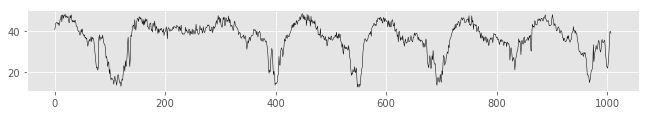

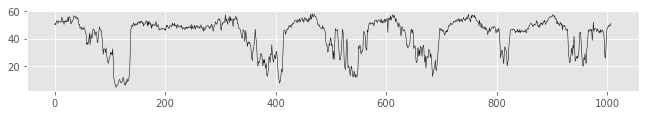

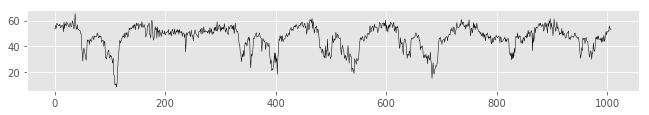

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(3):
    fig = plt.figure(figsize = (10, 1.5))
    ax = fig.add_axes([0.10, 0.22, 0.85, 0.75])
    plt.plot(X[i, :], color = "black", linewidth = 0.5)
    plt.show()

### 3.2 向量自回归预测

#### 1) 广州城市路网车速数据集

In [72]:
import time
start = time.time()

order_d = 5
N = X.shape[0]
pred_steps = 144 * 5
back_steps = 144 * 7 * 7
num_pred = 2
start_step = X.shape[1] - pred_steps
mat_hat = np.zeros((N, pred_steps))
for t in range(int(pred_steps/num_pred)):
    if t == 0:
        A, vec = var_model(X[:, 0 : t * num_pred + start_step], order_d, num_pred)
    else:
        A, vec = var_model(X[:, t * num_pred + start_step - back_steps : t * num_pred + start_step], order_d, num_pred)
    if num_pred == 1:
        mat_hat[:, t] = vec.reshape(N)
    else:
        mat_hat[:, t * num_pred : (t + 1) * num_pred] = vec
    if (t + 1) % 40 == 0:
        print('The current time step is {}.'.format(t + 1))

end = time.time()
print('Running time: %d seconds'%(end - start))

The current time step is 40.
The current time step is 80.
The current time step is 120.
The current time step is 160.
The current time step is 200.
The current time step is 240.
The current time step is 280.
The current time step is 320.
The current time step is 360.
Running time: 163 seconds


In [69]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[0] - pred_steps - 1 : X.shape[0] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.07592022207792891
RMSE: 3.3239367927223933


In [73]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[0] - pred_steps - 1 : X.shape[0] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.07624121606441021
RMSE: 3.380317837774733


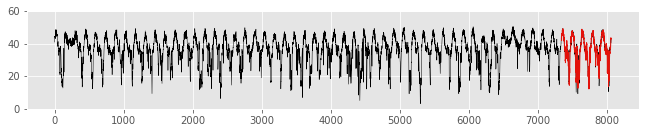

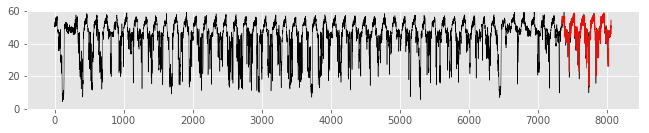

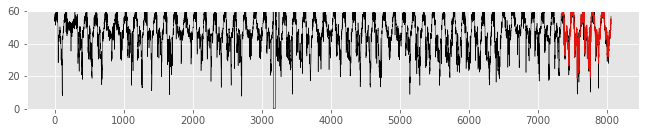

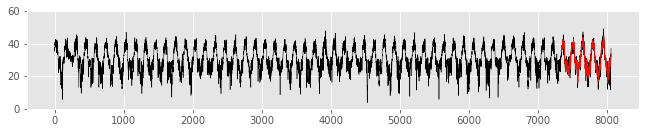

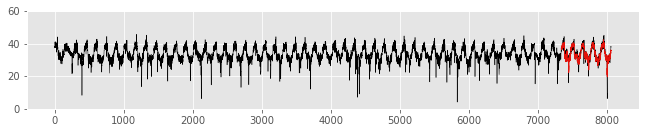

In [70]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(5):
    fig = plt.figure(figsize = (10, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps, X.shape[1])), mat_hat[i, :], color = "#e3120b", linewidth = 1.0)
    ax.set_ylim([0, 60])

#### 2) 杭州地铁客流量数据集

In [42]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
X = dense_mat[0 : 80, 0 :]

In [63]:
import time
start = time.time()

order_d = 5
N = X.shape[0]
pred_steps = 108 * 5
back_steps = 108 * 14
num_pred = 1
start_step = X.shape[1] - pred_steps
mat_hat = np.zeros((N, pred_steps))
for t in range(int(pred_steps/num_pred)):
    if t == 0:
        A, vec = var_model(X[:, 0 : t * num_pred + start_step], order_d, num_pred)
    else:
        A, vec = var_model(X[:, t * num_pred + start_step - back_steps : t * num_pred + start_step], order_d, num_pred)
    if num_pred == 1:
        mat_hat[:, t] = vec.reshape(N)
    else:
        mat_hat[:, t * num_pred : (t + 1) * num_pred] = vec
    if (t + 1) % 40 == 0:
        print('The current time step is {}.'.format(t + 1))

end = time.time()
print('Running time: %d seconds'%(end - start))

The current time step is 40.
The current time step is 80.
The current time step is 120.
The current time step is 160.
The current time step is 200.
The current time step is 240.
The current time step is 280.
The current time step is 320.
The current time step is 360.
The current time step is 400.
The current time step is 440.
The current time step is 480.
The current time step is 520.
Running time: 14 seconds


In [62]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[1] - pred_steps - 1 : X.shape[1] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.26236672083603335
RMSE: 31.900613700389265


In [64]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[1] - pred_steps - 1 : X.shape[1] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.2768121442363916
RMSE: 33.3916949483539


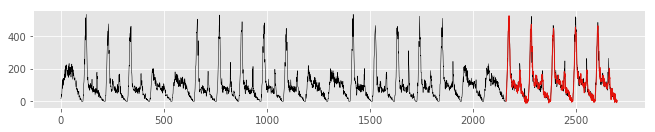

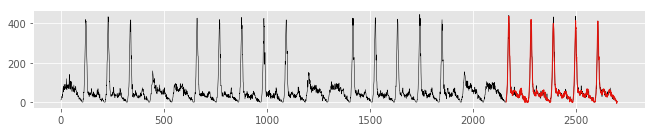

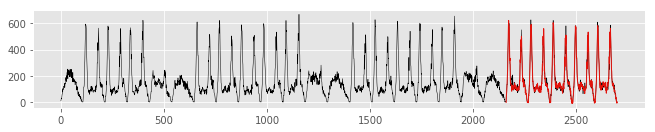

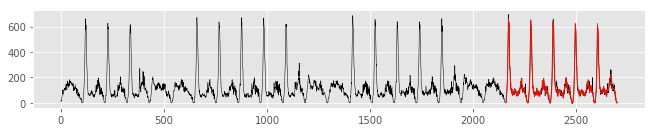

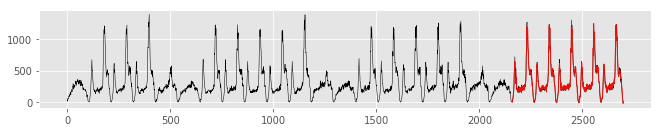

In [66]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(5):
    fig = plt.figure(figsize = (10, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps, X.shape[1])), mat_hat[i, :], color = "#e3120b", linewidth = 1.0)
#     ax.set_ylim([0, 600])